In [1]:
import transformers, datasets
transformers.utils.logging.set_verbosity_error()
datasets.utils.logging.set_verbosity_error()

# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [2]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')
print(len(dataset['test']))
smaller_dataset = dataset
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<18000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<2000, with_indices=True)

  0%|          | 0/2 [00:00<?, ?it/s]

400000


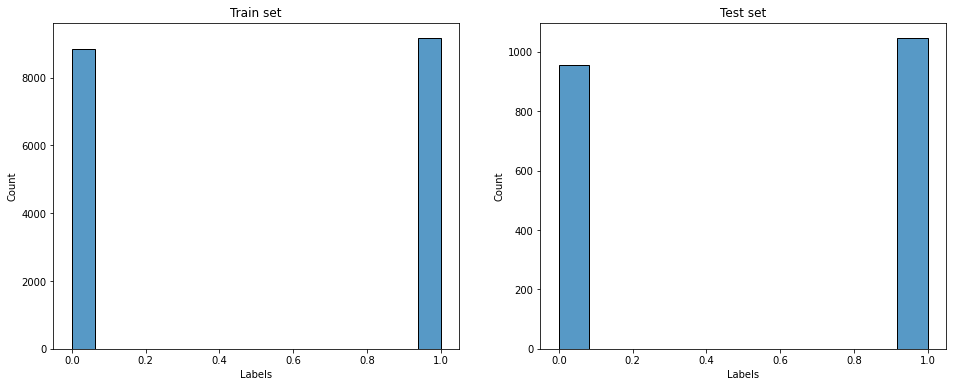

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(smaller_dataset["train"]["label"], ax=ax[0])
sns.histplot(smaller_dataset["test"]["label"], ax=ax[1])
ax[0].set_xlabel('Labels'); ax[1].set_xlabel('Labels');
ax[0].set_title('Train set'); ax[1].set_title('Test set');

### DistilBERT Tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function_distilbert(examples):
    return tokenizer_distilbert(examples["title"], truncation=True)

In [20]:
tokenized_dataset_distilbert = dataset.map(preprocess_function_distilbert, batched=True)
smaller_tokenized_dataset_distilbert = smaller_dataset.map(preprocess_function_distilbert, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

### RoBERTa Tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
def preprocess_function_roberta(examples):
    return tokenizer(examples["title"], truncation=True)

In [22]:
tokenized_dataset_roberta = dataset.map(preprocess_function_roberta, batched=True)
smaller_tokenized_dataset_roberta = smaller_dataset.map(preprocess_function_roberta, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

## Model

### DistilBERT

In [ ]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_distilbert = DataCollatorWithPadding(tokenizer=tokenizer_distilbert)
model_distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args_distilbert = TrainingArguments(
    output_dir="./results_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args_distilbert,
    train_dataset=smaller_tokenized_dataset_distilbert["train"],
    eval_dataset=smaller_tokenized_dataset_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    data_collator=data_collator_distilbert
)

trainer_distilbert.train()

In [ ]:
trainer_distilbert.save_model('distilbert')

**Load pretrained model**

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('./results_distilbert/checkpoint-6000/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_distilbert = DataCollatorWithPadding(tokenizer=tokenizer_distilbert)

training_args_distilbert = TrainingArguments(
    output_dir="./results_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args_distilbert,
    train_dataset=smaller_tokenized_dataset_distilbert["train"],
    eval_dataset=smaller_tokenized_dataset_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    data_collator=data_collator_distilbert
)

In [ ]:
import torch
import torch.nn.functional as F
predicted_distilbert = trainer_distilbert.predict(smaller_tokenized_dataset_distilbert["test"])

predicted_proba_distilbert = torch.tensor(predicted_distilbert.predictions)
predicted_softmax_distilbert = F.softmax(predicted_proba_distilbert, dim=1)

In [36]:
data_distilbert = predicted_proba_distilbert[:,1].numpy(), np.array(smaller_tokenized_dataset_distilbert["test"]["label"]), predicted_softmax_distilbert[:,1].numpy()

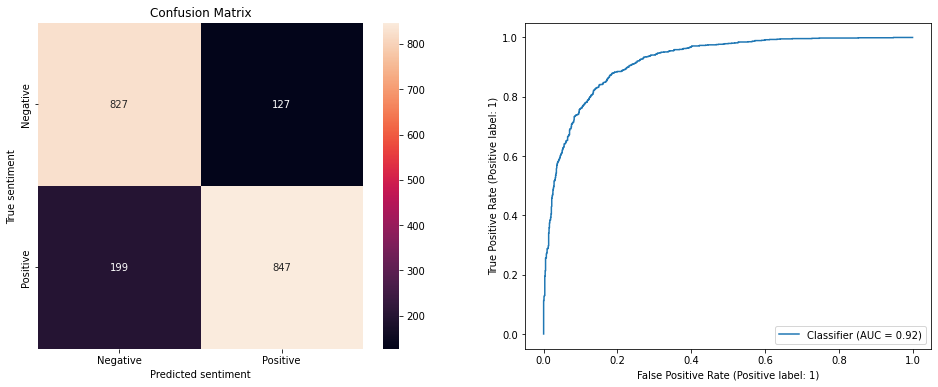

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_distilbert = (data_distilbert[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_distilbert[1], y_hat_distilbert), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_distilbert[1], predicted_proba[:,1], ax=ax[1])

## Model

### RoBERTa

In [ ]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)
model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=smaller_tokenized_dataset_roberta["train"],
    eval_dataset=smaller_tokenized_dataset_roberta["test"],
    tokenizer=tokenizer_roberta,
    data_collator=data_collator_roberta
)

trainer_roberta.train()

In [ ]:
trainer_roberta.save_model('roberta')

**Load pretrained model**

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('./roberta/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=smaller_tokenized_dataset_roberta["train"],
    eval_dataset=smaller_tokenized_dataset_roberta["test"],
    tokenizer=tokenizer_roberta,
    data_collator=data_collator_roberta
)

In [ ]:
import torch
import torch.nn.functional as F
predicted_roberta = trainer_roberta.predict(smaller_tokenized_dataset_roberta["test"])

predicted_proba_roberta = torch.tensor(predicted_roberta.predictions)
predicted_softmax_roberta = F.softmax(predicted_proba_roberta, dim=1)

In [29]:
data_roberta = predicted_proba_roberta[:,1].numpy(), np.array(smaller_tokenized_dataset_roberta["test"]["label"]), predicted_softmax_roberta[:,1].numpy()

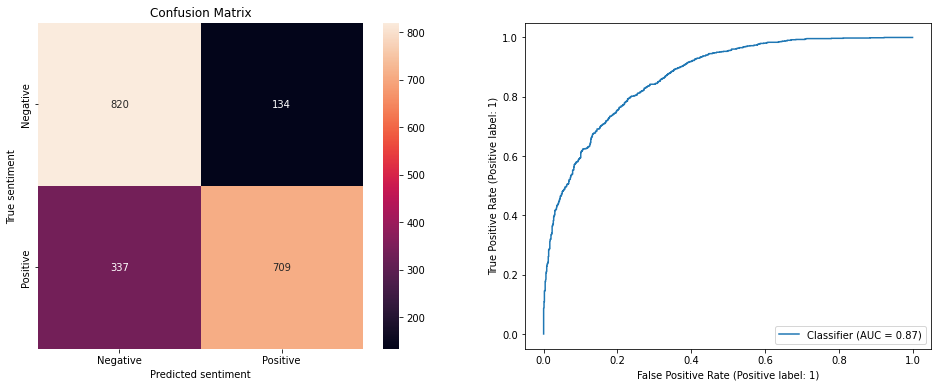

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_roberta = (data_roberta[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_roberta[1], y_hat_roberta), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_roberta[1], predicted_proba_roberta[:,1], ax=ax[1])

## Evaluation

**Supporting code**

In [52]:
import VennAbers
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil, exp
from sklearn.calibration import CalibratedClassifierCV

def plot_all_score(data):
    rng = np.array(list(range(floor(data[0].min()*100), ceil(data[0].max()*100), 1))) / 100
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), rng)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(rng)
    
    ps = CalibratedClassifierCV()
    ps.fit(data[0].reshape(-1, 1), data[1])
    platt_scaling = ps.predict_proba(rng.reshape(-1, 1))[:,1]
    
    plt.figure(figsize=(10,10))
    #sns.lineplot(x=rng, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(rng, venn_abers[0], venn_abers[1], color='orange', alpha=1)
    #sns.lineplot(x=rng, y=predicted_proba, linestyle='dotted')
    sns.lineplot(x=rng, y=platt_scaling)
    sns.lineplot(data[0], data[2], color='green', alpha=.65)
    plt.axis((floor(data[0].min()), ceil(data[0].max()), 0, 1))
    
    #xpoints = ypoints = plt.xlim()
    #plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(floor(data[0].min()), ceil(data[0].max())+0.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers Interval", "Platt Scaling", "Softmax"])
    plt.xlabel('Score'); plt.ylabel('Calibrated probability')

### DistilBERT

/Users/q_user/miniforge3/envs/nlp_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


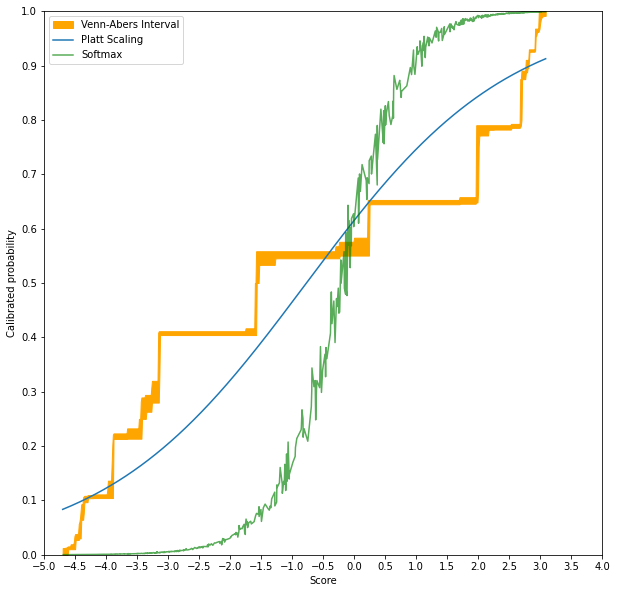

In [53]:
plot_all_score(data_distilbert)

### RoBERTa

/Users/q_user/miniforge3/envs/nlp_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


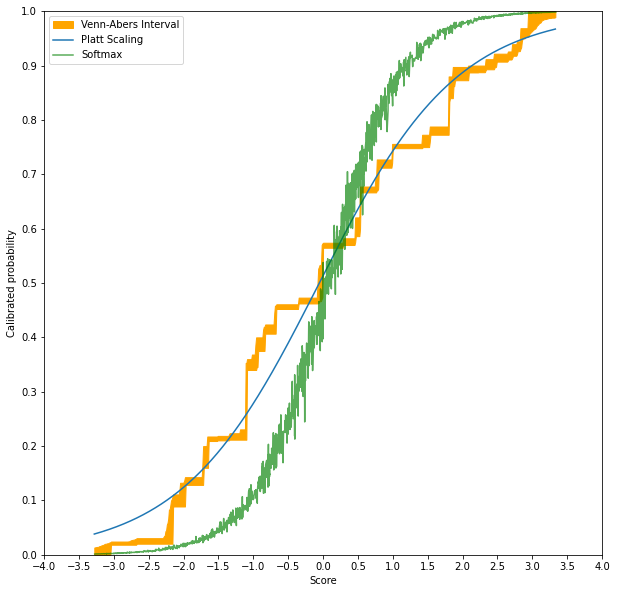

In [54]:
plot_all_score(data_roberta)

## Time evaluation

In [15]:
import time
import VennAbers
from tqdm import tqdm
data_time_eval = data_bert

In [16]:
def time_eval_slow(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        for s_x_test in (np.array(list(range(0, 101, 1))) / 100):
            venn_abers = VennAbers.venn_abers(list(zip(data_time_eval[0], data_time_eval[1])), s_x_test)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [17]:
def time_eval_fast(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        venn_abers = VennAbers.venn_abers_fast(list(zip(data_time_eval[0], data_time_eval[1])), np.array(list(range(0, 101, 1))) / 100)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [18]:
time_slow, time_fast = time_eval_slow(), time_eval_fast()
print(f"Slow Venn-Abers (avg. - 100 runs): {round(time_slow)} ms")
print(f"Fast Venn-Abers (avg. - 100 runs): {round(time_fast)} ms")
print(f"Average speed-up of {round((1/time_fast) / (1/time_slow), 1)}x (100 runs)")

Slow Venn-Abers (avg. - 100 runs): 164 ms
Fast Venn-Abers (avg. - 100 runs): 81 ms
Average speed-up of 2.0x (100 runs)
